In [1]:
import xarray as xr

In [2]:
from utils import *

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.91:33255,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
def dashboard_wrangling(param, var):
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)

    Plot1 = accuracy_plot(results_df) 
    Plot2 = emulator_plot(results_df)
    
    return Plot1, Plot2

Training R^2: 0.74653039015835
Training RMSE: 3.54071238358866e-06
Mean Absolute Error: 2.5008176225625332e-06


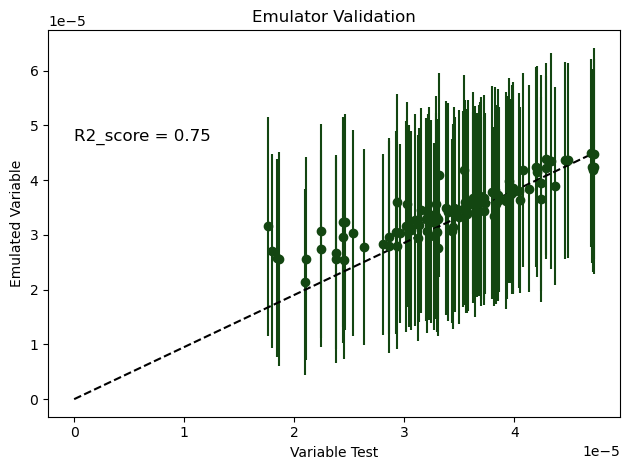

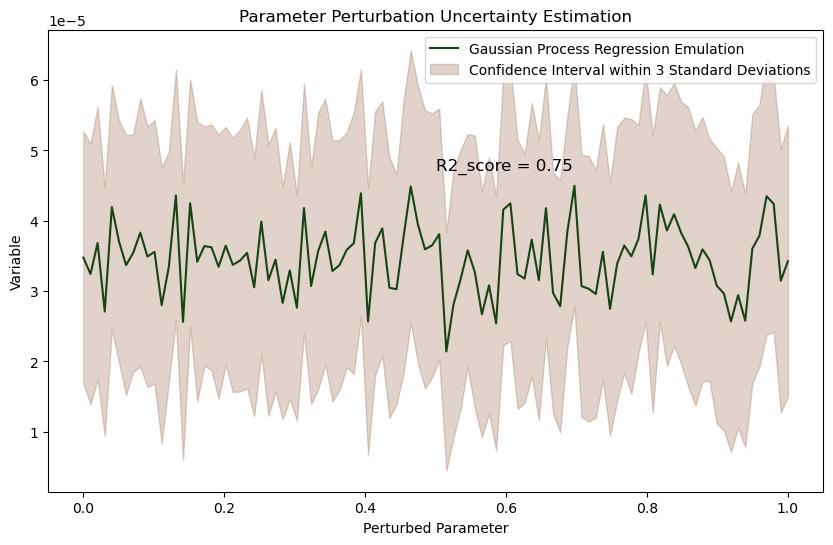

(None, None)

In [18]:
dashboard_wrangling('leafcn', 'GPP')